# Определение возрастра покупателей

**Краткая информация о проекте:**
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**План работы:**
1. Провести загрузку данных и знакомство с ними;
2. Провести анализ данных;
3. Провести обучение нейронной сети и расчет метрики качества (задача регрессии - МАЕ).

**Цель и задачи проекта:**
- **Цель** - обучить нейронную сеть для определения возраста покупателей.
- **Задачи:**
1. Провести загрузку данных и знакомство с ними;
2. Провести анализ данных;
3. Провести обучение нейронной сети и расчет метрики качества (задача регрессии - МАЕ).

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(labels.head(15))
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

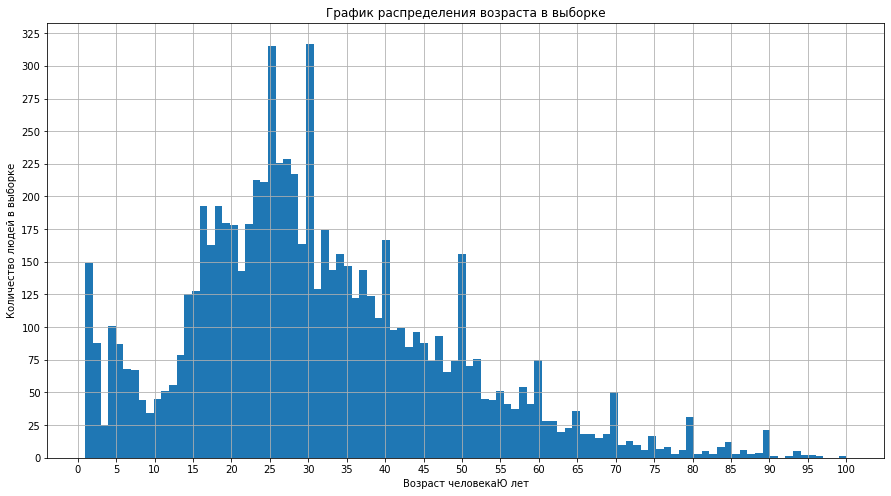

In [4]:
display(labels['real_age'].describe())
display(labels['real_age'].value_counts().head())

plt.figure(figsize=(15, 8))
plt.hist(labels['real_age'], bins=100)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст человекаЮ лет')
plt.ylabel('Количество людей в выборке')
plt.xticks([x for x in range(0, 101, 5)])
plt.yticks([x for x in range(0, 350, 25)])
plt.grid()
plt.show()

**Вывод по графику:** в выборке представлено **7 591** фотографий людей. Возраст людей лежит в диапазоне **от 1 до 100 лет**. У большей части людей на фотографиях возраст лежит в диапазоне **от 20 до 41 года**. Максимальное количество людей в возрасте **30 (317) и 25 (315) лет**. 

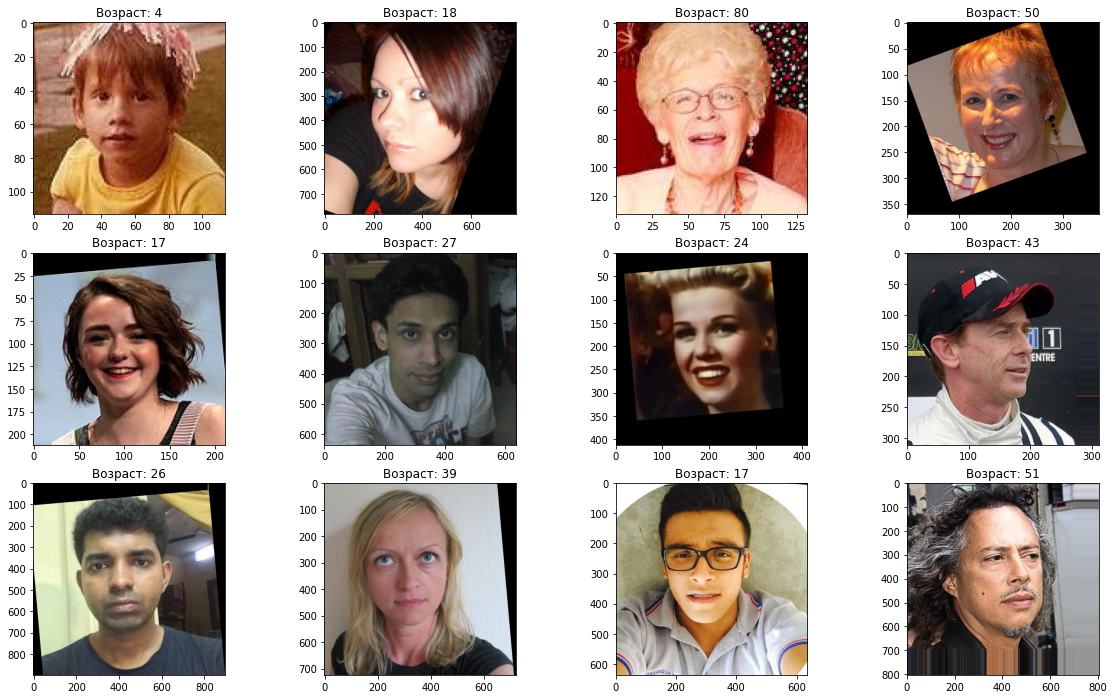

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))

i, j = 0, 0
for num in range(12):
    if num < 10:
        path = '/datasets/faces/final_files/00000' + str(num) + '.jpg'
    else:
        path = '/datasets/faces/final_files/0000' + str(num) + '.jpg'
    image = Image.open(path)
    image_array = np.array(image)
    ax[i, j].imshow(image_array)
    ax[i, j].set_title('Возраст: {}'.format(labels['real_age'][num]))
    if j < 3:
        j += 1
    else: 
        i += 1
        j = 0

**Выводы по EDA:** в связи с неравномерным распределением возраста в наблюдениях, вероятнее всего, модель будет лучше предсказывать возраст людей до 65 лет. Модель, возможно, будет неточно предсказывать возраст людей 65+.

## Обучение нейронной сети

In [3]:
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25,
                                       horizontal_flip=True, width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df, directory=path+'/final_files',    
                                                           x_col='file_name', y_col='real_age',
                                                           target_size=(224,224), batch_size=32,
                                                           class_mode='raw', subset='training',  
                                                           seed = 12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df, directory=path+'/final_files',
                                                         x_col='file_name', y_col='real_age',
                                                         target_size=(224,224), batch_size=32,
                                                         class_mode='raw', subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=2, shuffle=True)
    return model

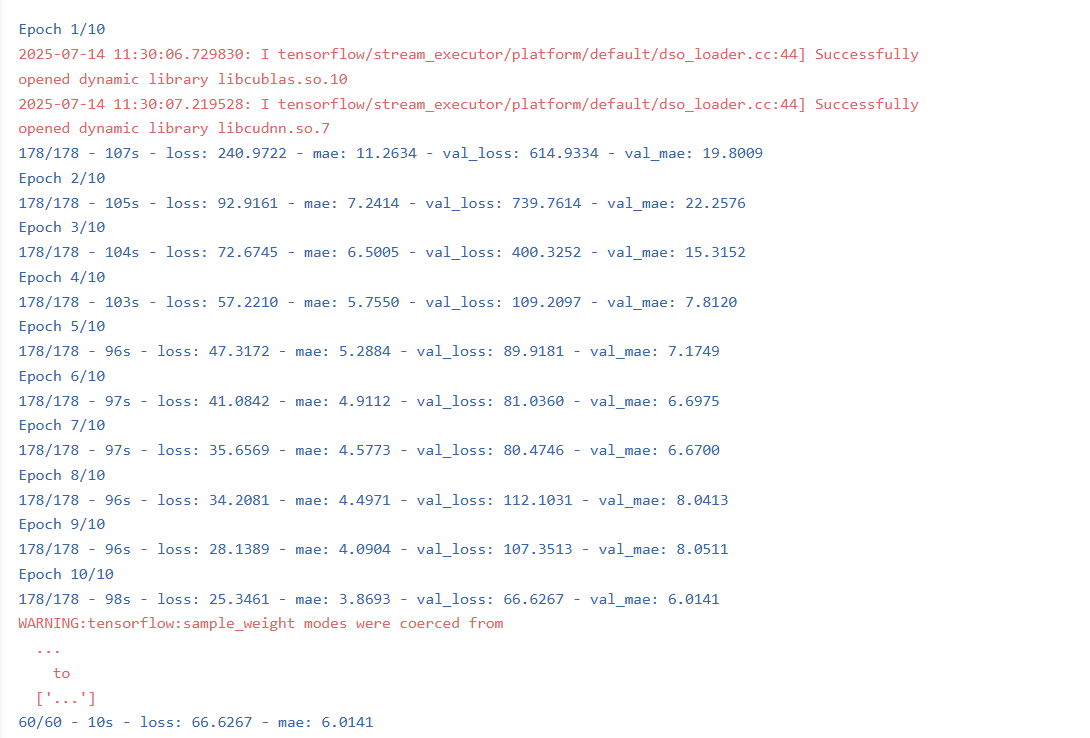

**Выводы по обучению нейронной сети:** для достижения цели проекта была обучена нейронная сеть со следующей архитектурой:
- В основе модели предобученная нейронная сеть `ResNet50` с замороженным верхним слоем;
- Для оптимизация модели использовался алгоритм `Adam`;
- В целях лучшего обучения была использована аугементация фотографий;
- Метрика качества соответствует требованиям проекта - `МАЕ = 6.01 (<7)`.